## 1.Project Setup

In [58]:
import pandas as pd

## 2.Data Management

### 2.1.Data Loading and Concatenation

In [59]:
rental_df = pd.read_csv("RentingOutofFlats.csv")
rental_df

,rent_approval_date,town,block,street_name,flat_type,monthly_rent
0,2021-01,ANG MO KIO,105,ANG MO KIO AVE 4,4-ROOM,2000
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3-ROOM,1750
2,2021-01,ANG MO KIO,108,ANG MO KIO AVE 4,3-ROOM,1750
3,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2230
4,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2450
...,...,...,...,...,...,...
109314,2023-12,QUEENSTOWN,59,STRATHMORE AVE,4-ROOM,4100
109315,2023-12,WOODLANDS,681D,WOODLANDS DR 62,4-ROOM,3300
109316,2023-12,CHOA CHU KANG,354,CHOA CHU KANG CTRL,4-ROOM,2950
109317,2023-12,YISHUN,717,YISHUN ST 71,4-ROOM,3200


In [60]:
rental_df.describe()

,monthly_rent
count,109319.000000
mean,2554.176694
std,721.449795
min,300.000000
25%,2000.000000
50%,2400.000000
75%,3000.000000
max,7600.000000


## 2.2.Initial Data Processing

**Convert columns to appropriate formats and perform initial transformations.**

In [61]:
rental_df['flat_type'].unique()

array(['4-ROOM', '3-ROOM', '5-ROOM', '2-ROOM', 'EXECUTIVE', '1-ROOM'],
      dtype=object)

In [62]:
rental_df.rename(columns={'rent_approval_date':'rent_approval_month'},inplace=True)
rental_df['rent_approval_month'] = pd.to_datetime(rental_df['rent_approval_month'])
rental_df['rent_approval_year'] = rental_df['rent_approval_month'].dt.year
rental_df['rent_approval_month'] = rental_df['rent_approval_month'].dt.month
rental_df

,rent_approval_month,town,block,street_name,flat_type,monthly_rent,rent_approval_year
0,1,ANG MO KIO,105,ANG MO KIO AVE 4,4-ROOM,2000,2021
1,1,ANG MO KIO,107,ANG MO KIO AVE 4,3-ROOM,1750,2021
2,1,ANG MO KIO,108,ANG MO KIO AVE 4,3-ROOM,1750,2021
3,1,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2230,2021
4,1,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2450,2021
...,...,...,...,...,...,...,...
109314,12,QUEENSTOWN,59,STRATHMORE AVE,4-ROOM,4100,2023
109315,12,WOODLANDS,681D,WOODLANDS DR 62,4-ROOM,3300,2023
109316,12,CHOA CHU KANG,354,CHOA CHU KANG CTRL,4-ROOM,2950,2023
109317,12,YISHUN,717,YISHUN ST 71,4-ROOM,3200,2023


In [63]:
rental_df.groupby('flat_type')['flat_type'].value_counts()

flat_type
1-ROOM          29
2-ROOM        2016
3-ROOM       35586
4-ROOM       39219
5-ROOM       26248
EXECUTIVE     6221
Name: count, dtype: int64

## 3.Feature Engineering and Preparation

### 3.1. Nearest Amenities

In [64]:
mrt_locations = pd.read_csv("sg-mrt-existing-stations.csv")
mrt_locations.rename(columns= {"latitude": "lat", "longitude": "lng"}, inplace=True)
mrt_upcoming = pd.read_csv("sg-mrt-planned-stations.csv")
mrt_upcoming.rename(columns={'latitude': 'lat', 'longitude': 'lng'}, inplace=True)
school_locations = pd.read_csv("sg-primary-schools.csv")
school_locations.rename(columns={'latitude': 'lat', 'longitude': 'lng'}, inplace=True)
mall_locations = pd.read_csv("sg-shopping-malls.csv")
mall_locations.rename(columns={'latitude': 'lat', 'longitude': 'lng'}, inplace=True)
zipcode_mapper = pd.read_csv('sg_zipcode_mapper_utf.csv')
zipcode_mapper.rename(columns = {"latitude": "lat", "longtitude": "lng","blk_no": "block", "RD_name": "street_name"},inplace=True)

In [65]:
rental_df = pd.merge(rental_df, zipcode_mapper[['block', 'street_name', 'lat', 'lng']], how='left',
                        on = ['block', 'street_name'])

In [66]:
rental_df.dropna(inplace=True)
rental_df.drop_duplicates(inplace=True)
rental_df.reset_index(inplace=True)

In [67]:
from sklearn.neighbors import NearestNeighbors

nn_model_mrt = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='haversine')
nn_model_mrt.fit(mrt_locations[['lat', 'lng']])
rental_df['mrt_dist'], indices = nn_model_mrt.kneighbors(rental_df[['lat', 'lng']])

nn_model_school = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='haversine')
nn_model_school.fit(school_locations[['lat', 'lng']])
rental_df['school_dist'], indices = nn_model_school.kneighbors(rental_df[['lat', 'lng']])

nn_model_mall = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='haversine')
nn_model_mall.fit(mall_locations[['lat', 'lng']])
rental_df['mall_dist'], indices = nn_model_mall.kneighbors(rental_df[['lat', 'lng']])

nn_model_mrt_upcoming = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='haversine')
nn_model_mrt_upcoming.fit(mrt_upcoming[['lat', 'lng']])
rental_df['upcoming_mrt_dist'], indices = nn_model_mrt_upcoming.kneighbors(rental_df[['lat', 'lng']])

In [68]:
rental_df.drop(columns=['lat', 'lng'], inplace=True)

### 3.2. Remove outliers and not-so-important features

In [69]:
rental_df = rental_df[~rental_df['flat_type'].isin(['1-ROOM'])]

In [70]:
rental_df.drop(columns=['street_name','block'], inplace=True)

### 3.3. Regional feature mapping

In [71]:
regions_mapper = {'ANG MO KIO':'North East', 'BEDOK':'East', 'BISHAN':'Central', 'BUKIT BATOK':'West', 'BUKIT MERAH':'Central',
       'BUKIT PANJANG':'West', 'BUKIT TIMAH':'Central', 'CENTRAL':'North', 'CHOA CHU KANG':'West',
       'CLEMENTI':'West', 'GEYLANG':'Central', 'HOUGANG':'North East', 'JURONG EAST':'West', 'JURONG WEST':'West',
       'KALLANG/WHAMPOA':'Central', 'MARINE PARADE':'Central', 'PASIR RIS':'East', 'PUNGGOL':'North East',
       'QUEENSTOWN':'Central', 'SEMBAWANG':'North', 'SENGKANG':'North East', 'SERANGOON':'North East', 'TAMPINES':'East',
       'TOA PAYOH':'Central', 'WOODLANDS':'North', 'YISHUN':'North'}

rental_df['region'] = rental_df['town'].map(regions_mapper)
rental_df.drop(columns=['index'],inplace=True)

### 3.4. Pipeline transformer - encoding of town, region and flat types

In [72]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
categories = [sorted(rental_df['flat_type'].unique())]
column_transformer = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories=categories, dtype=int), ['flat_type']),
        ('region_one_hot', OneHotEncoder(dtype=int, sparse_output=False), ['region']),
        ('town_one_hot', OneHotEncoder(dtype=int, sparse_output=False), ['town'])
    ],
    remainder='passthrough'
)

def increment(X):
    X[:, 0] += 1
    return X

# Create the pipeline
pipeline = Pipeline(steps=[
    ('encode', column_transformer),
    ('increment', FunctionTransformer(increment))
])

transformed_data = pipeline.fit_transform(rental_df)

new_column_names = ['flat_type'] + \
                   [f'model_{feat}' for feat in pipeline.named_steps['encode'].transformers_[1][1].get_feature_names_out()] + \
                   [f'model_{feat}' for feat in pipeline.named_steps['encode'].transformers_[2][1].get_feature_names_out()] + \
                   [col for col in rental_df.columns if col not in ['flat_type', 'region', 'town']]

rental_df_transformed = pd.DataFrame(transformed_data, columns=new_column_names)

rental_df  = rental_df_transformed

rental_df

,flat_type,model_region_Central,model_region_East,model_region_North,model_region_North East,model_region_West,model_town_ANG MO KIO,model_town_BEDOK,model_town_BISHAN,model_town_BUKIT BATOK,...,model_town_TOA PAYOH,model_town_WOODLANDS,model_town_YISHUN,rent_approval_month,monthly_rent,rent_approval_year,mrt_dist,school_dist,mall_dist,upcoming_mrt_dist
0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2000.0,2021.0,0.000874,0.001792,0.001690,0.020070
1,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1750.0,2021.0,0.000180,0.002668,0.001783,0.019460
2,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1750.0,2021.0,0.000593,0.003004,0.001816,0.019341
3,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2230.0,2021.0,0.000629,0.003185,0.002029,0.019128
4,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2450.0,2021.0,0.000629,0.003185,0.002029,0.019128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106037,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12.0,4100.0,2023.0,0.001963,0.002608,0.004531,0.016066
106038,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,12.0,3300.0,2023.0,0.000656,0.000179,0.000498,0.029058
106039,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12.0,2950.0,2023.0,0.002722,0.001103,0.002444,0.002451
106040,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,12.0,3200.0,2023.0,0.003962,0.001965,0.002745,0.016243


### 3.5. Month cyclic feature encoding

In [73]:
import numpy as np
rental_df['month_sin'] = np.sin((rental_df.rent_approval_month-1)*(2.*np.pi/12))
rental_df['month_cos'] = np.cos((rental_df.rent_approval_month-1)*(2.*np.pi/12))
rental_df.drop(columns=['rent_approval_month'], inplace=True)

## 4.Model Development and Evaluation

#### 4.1.Generation of Feature Correlation Matrix

In [74]:
corr_matrix = rental_df[['monthly_rent','month_sin','month_cos','flat_type','rent_approval_year','mrt_dist','upcoming_mrt_dist','school_dist','mall_dist']].corr()

# Round correlations to two decimals
corr_matrix = round(corr_matrix, 2)

# Create a mask to set the values in the upper triangle of the correlation matrix to NaN
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_matrix[mask] = np.nan

# Show correlation matrix
corr_matrix

,monthly_rent,month_sin,month_cos,flat_type,rent_approval_year,mrt_dist,upcoming_mrt_dist,school_dist,mall_dist
monthly_rent,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month_sin,-0.11,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month_cos,-0.03,-0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN
flat_type,0.33,0.01,0.01,1.00,NaN,NaN,NaN,NaN,NaN
rent_approval_year,0.53,-0.01,-0.00,-0.02,1.00,NaN,NaN,NaN,NaN
mrt_dist,-0.04,0.00,0.00,0.08,-0.00,1.00,NaN,NaN,NaN
upcoming_mrt_dist,-0.02,-0.01,0.01,0.15,-0.01,-0.09,1.00,NaN,NaN
school_dist,0.02,-0.00,-0.00,-0.17,0.00,0.11,-0.18,1.00,NaN
mall_dist,-0.03,0.01,-0.00,-0.13,-0.00,0.18,-0.14,0.07,1.0


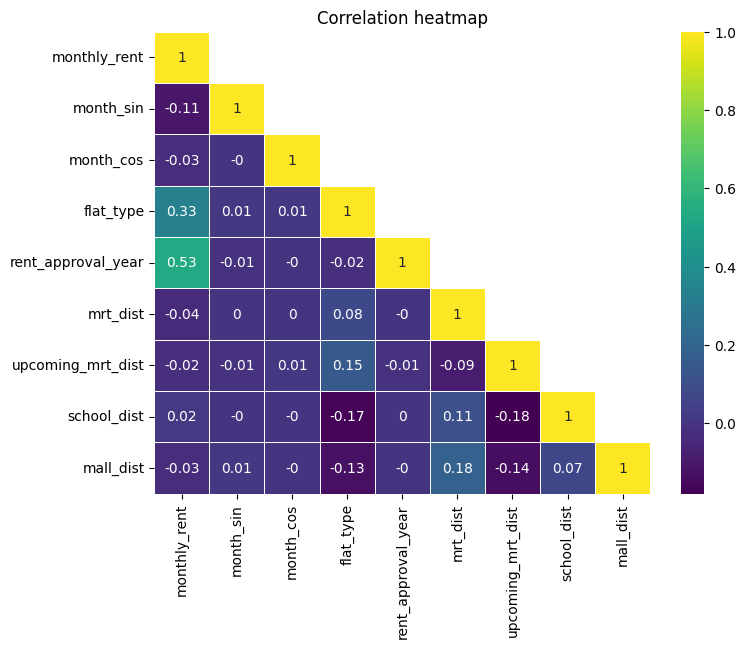

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(corr_matrix, cmap="viridis", annot=True, linewidth=0.5)

# Add title
plt.title("Correlation heatmap")

# Show the plot
plt.show()

#### 4.2.Training-Testing Data Split

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X = rental_df.drop(columns=['monthly_rent'], axis=1)
y = rental_df['monthly_rent']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## 4.3 Model training

#### 4.3.1.Linear Model Variants (Linear Regression, Ridge Regression)

In [77]:
from sklearn.linear_model import LinearRegression

# Creating a LinearRegression model
lr_model = LinearRegression()

# Training the model
lr_model.fit(X_train, y_train)

# Predicting on the test set
y_pred_lr = lr_model.predict(X_test)

# Calculating the performance metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_lr, r2_lr


(270382.2360334848, 0.4749365872739233)

In [78]:
print(f'RMSE for LR: {mse_lr**0.5}')

RMSE for LR: 519.9829189824266


In [79]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_ridge = {'alpha': [0.1, 1, 10, 100]}

# Create the Ridge model
ridge_model = Ridge()

# Instantiate the grid search model
grid_search_ridge = GridSearchCV(estimator=ridge_model, param_grid=param_grid_ridge, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_ridge.fit(X_train, y_train)

# Best parameters and score
best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_

best_params_ridge, best_score_ridge


({'alpha': 0.1}, -274499.75709258596)

In [80]:
print(f'RMSE for Ridge: {(-best_score_ridge)**0.5}')

RMSE for Ridge: 523.9272440831703


In [81]:
y_pred_test = grid_search_ridge.best_estimator_.predict(X_test)

# Calculate R^2 score
r2_test = r2_score(y_test, y_pred_test)

print(f"R^2 score for the test set: {r2_test}")

R^2 score for the test set: 0.4745504493456487


#### 4.3.2.Random Forest Regressor

In [82]:
from sklearn.ensemble import RandomForestRegressor

# Creating a RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=0)

# Training the model
rf_regressor.fit(X_train, y_train)

# Predicting on the test set
y_pred_rf = rf_regressor.predict(X_test)

# Calculating the performance metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"MSE for RandomForestRegressor: {mse_rf}")
print(f"R^2 for RandomForestRegressor: {r2_rf}")


MSE for RandomForestRegressor: 269063.7272839137
R^2 for RandomForestRegressor: 0.4774970391509219


In [83]:
print(f"RMSE for RandomForestRegressor: {mse_rf**0.5}")

RMSE for RandomForestRegressor: 518.7135310399312


#### 4.3.3.KNN Neighbors with Grid Search

In [84]:
from sklearn.neighbors import KNeighborsRegressor

# Creating a KNeighborsRegressor model
knn_regressor = KNeighborsRegressor(n_neighbors=5)

# Training the model
knn_regressor.fit(X_train, y_train)

# Predicting on the test set
y_pred_knn = knn_regressor.predict(X_test)

# Calculating performance metrics
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"MSE for KNeighborsRegressor: {mse_knn}")
print(f"R^2 for KNeighborsRegressor: {r2_knn}")


MSE for KNeighborsRegressor: 279786.57632703095
R^2 for KNeighborsRegressor: 0.4566740154370842


In [85]:
print(f"RMSE for KNeighborsRegressor: {mse_knn**0.5}")


RMSE for KNeighborsRegressor: 528.9485573541448


In [86]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

best_params_knn = grid_search_knn.best_params_
best_score_knn = -grid_search_knn.best_score_

best_params_knn,best_score_knn

({'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'},
 267865.7010395088)

In [87]:
print(f"RMSE for Grid Search KNN: {best_score_knn**0.5}")

RMSE for Grid Search KNN: 517.5574374303868


In [88]:
y_pred_test = grid_search_knn.best_estimator_.predict(X_test)

# Calculate R^2 score
r2_test = r2_score(y_test, y_pred_test)

print(f"R^2 score for the test set: {r2_test}")

R^2 score for the test set: 0.49508070360762113


#### 4.3.4. Initial AdaBoost Regressor model

In [89]:
from sklearn.ensemble import AdaBoostRegressor

# Creating an AdaBoostRegressor model
ada_model = AdaBoostRegressor(n_estimators=100, random_state=0)

# Training the model
ada_model.fit(X_train, y_train)

# Predicting on the test set
y_pred_ada = ada_model.predict(X_test)

# Calculating the performance metrics
mse_ada = mean_squared_error(y_test, y_pred_ada)
r2_ada = r2_score(y_test, y_pred_ada)

mse_ada, r2_ada


(299443.45631116856, 0.4185017277919003)

#### 4.3.5. Initial XGBoost Regressor model

In [90]:
from xgboost import XGBRegressor

# Creating an XGBRegressor model
xgb_model = XGBRegressor(n_estimators=100, random_state=0)

# Training the model
xgb_model.fit(X_train, y_train)

# Predicting on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculating the performance metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

mse_xgb, r2_xgb


(229392.38320919542, 0.5545360177941874)

#### 4.3.6. AdaBoost Regressor model with GridSearchCV

In [91]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

# Create the AdaBoostRegressor model
ada_model = AdaBoostRegressor(random_state=0)

# Instantiate the grid search model
grid_search_ada = GridSearchCV(estimator=ada_model, param_grid=param_grid_ada, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_ada.fit(X_train, y_train)

# Best parameters and score
best_params_ada = grid_search_ada.best_params_
best_score_ada = grid_search_ada.best_score_

best_params_ada, best_score_ada

({'learning_rate': 0.1, 'n_estimators': 100}, -295142.0968163177)

In [92]:
y_pred_test = grid_search_ada.best_estimator_.predict(X_test) 

# Calculate R^2 score
r2_test = r2_score(y_test, y_pred_test)

print(f"R^2 score for the test set: {r2_test}")

R^2 score for the test set: 0.4325113310099167


In [93]:
print(f"RMSE for Grid Search Ada: {(-best_score_ada)**0.5}")

RMSE for Grid Search Ada: 543.2698195338277


#### 4.3.7. XGBoost Regressor model with GridSearchCV

In [94]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Create the XGBRegressor model
xgb_model = XGBRegressor(random_state=0)

# Instantiate the grid search model
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_xgb.fit(X_train, y_train)

# Best parameters and score
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

best_params_xgb, best_score_xgb


({'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300},
 -235134.08710393807)

In [95]:
y_pred_test = grid_search_xgb.best_estimator_.predict(X_test) 

# Calculate R^2 score
r2_test = r2_score(y_test, y_pred_test)

print(f"R^2 score for the test set: {r2_test}")

R^2 score for the test set: 0.5555568924015328


In [96]:
print(f"RMSE for Grid Search XGB: {(-best_score_xgb)**0.5}")

RMSE for Grid Search XGB: 484.9062663071473
